# Compile annual mean O$_2$ fluxes from Gruber et al. 2001

In [1]:
%matplotlib inline
from config_calc import *
import grid_tools

from collections import OrderedDict

import matplotlib.pyplot as plt

### Make a basin mask on 1x1 grid

read ascii mask files from NODC and make some regional aggregations

Mask files downloaded from:
   https://www.nodc.noaa.gov/OC5/woa13/masks13.html
   
Documentation found here: https://data.nodc.noaa.gov/woa/WOA13/DOC/woa13documentation.pdf

In [2]:
nx = 360
ny = 180
ds = grid_tools.generate_latlon_grid(nx=nx,ny=ny,lon0=-180.)
ds['mask'] = xr.DataArray(np.zeros(ds.area.shape).astype(int),dims=('lat','lon'))
ds['kmt'] = xr.DataArray(np.zeros(ds.area.shape).astype(int),dims=('lat','lon'))

#--- basin mask
# The basin_XX.msk contains the basin code number defined for each grid square at each
# standard depth from the surface to 5500m. Each basin is identified by a code number that
# ranges from 1 to 58. The basin code number in a given quarter-degree and one-degree square
# may change with increased depth level. Appendix 1 lists the geographic basin names, the
# code number associated with each basin, and the standard depth level at which the given
# basin is first encountered.
import csv

lat_ndx = 0
lon_ndx = 1
mask_ndx = 2

csvfile = 'data/basinmask_01.msk'
with open(csvfile,'rb') as f:
    csvdata = csv.reader(f, delimiter=',',skipinitialspace=True)

    for ir,row in enumerate(csvdata):
        if ir < 2:
            pass
        else:
            j = np.where(ds.lat == float(row[lat_ndx]))[0]
            i = np.where(ds.lon == float(row[lon_ndx]))[0]
            if len(j) == 0 or len(i) == 0:
                print('ERROR: no match')
                break
            ds.mask.values[j,i] = int(row[mask_ndx])

            
#--- land sea mask
# The landsea_XX.msk contains the standard depth level number at which the bottom of the
# ocean is first encountered at each quarter-degree or one-degree square for the entire world.
# Land will have a value of 1

lat_ndx = 0
lon_ndx = 1
mask_ndx = 2

csvfile = 'data/landsea_01.msk'
with open(csvfile,'rb') as f:
    csvdata = csv.reader(f, delimiter=',',skipinitialspace=True)

    for ir,row in enumerate(csvdata):
        if ir < 2:
            pass
        else:
            j = np.where(ds.lat == float(row[lat_ndx]))[0]
            i = np.where(ds.lon == float(row[lon_ndx]))[0]
            ds.kmt.values[j,i] = int(row[mask_ndx])            

ds['mask_orig'] = ds.mask.copy()
ds  

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, nv: 4)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
Dimensions without coordinates: nv
Data variables:
    xc         (lat, lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
    yc         (lat, lon) float64 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 ...
    xv         (lat, lon, nv) float64 -180.0 -179.0 -179.0 -180.0 -179.0 ...
    yv         (lat, lon, nv) float64 -90.0 -90.0 -89.0 -89.0 -90.0 -90.0 ...
    area       (lat, lon) float64 1.079e+08 1.079e+08 1.079e+08 1.079e+08 ...
    mask       (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    kmt        (lat, lon) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    mask_orig  (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...

Make some ammendments: extend the Atlantic basin definition to encompass the Lab. and GIN Sea regions

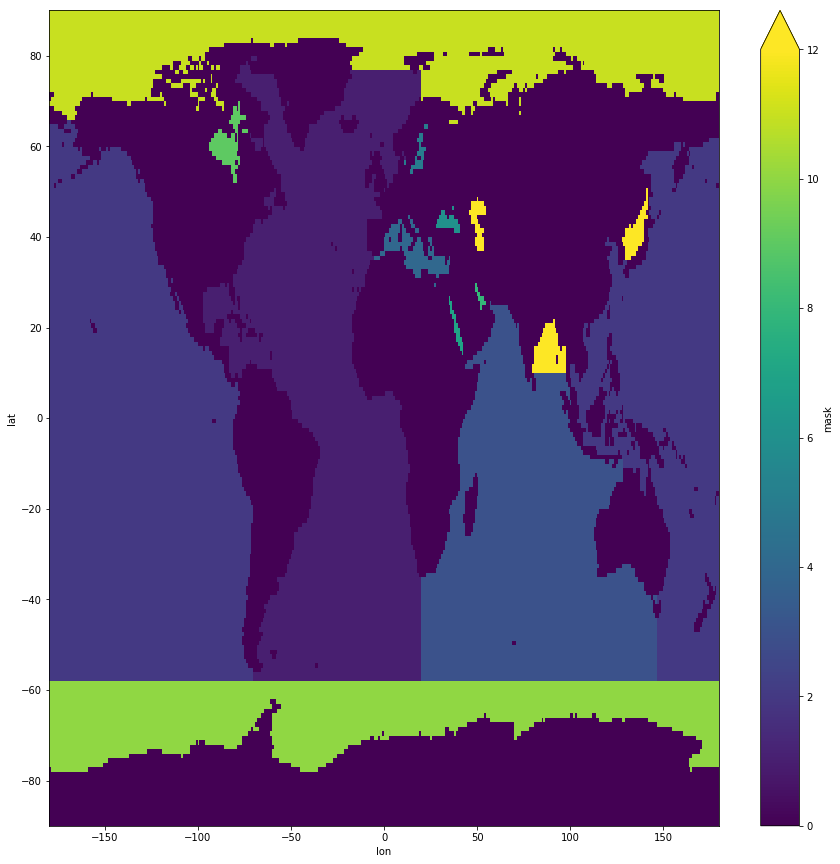

In [3]:
#-- change GIN Sea to Atlantic
ds.mask.values = np.where(
    (55<ds.lat) & (ds.lat<77) & 
    (ds.mask_orig==11.) & (ds.lon>-45.) & (ds.lon<20.), 1., ds.mask_orig.values)

#-- change Lab Sea to Atlantic
ds.mask.values = np.where(
    (55<ds.lat) & (ds.lat<80) & 
    (ds.mask_orig==11.) & (-80<ds.lon) & (ds.lon<-45.), 1., ds.mask.values)

#-- change definition of Southern Ocean to encompass region south of Terra del Fuego
# atlantic
ds.mask.values = np.where(
    (-58.<ds.lat) & (ds.mask_orig==10.) & 
    (-70<ds.lon) & (ds.lon<20.), 1., ds.mask.values)

# pacific
ds.mask.values = np.where(
    (-58.<ds.lat) & (ds.mask_orig==10.) & 
    ((147<=ds.lon) | (ds.lon<=-70.)), 2., ds.mask.values)

# indian
ds.mask.values = np.where(
    (-58.<ds.lat) & (ds.mask_orig==10.) & 
    (20<ds.lon) & (ds.lon<147), 3., ds.mask.values)

fig = plt.figure(figsize=(15,15))
ds.mask.plot(vmin=0,vmax=12)

Aggregate regions into a basin mask.

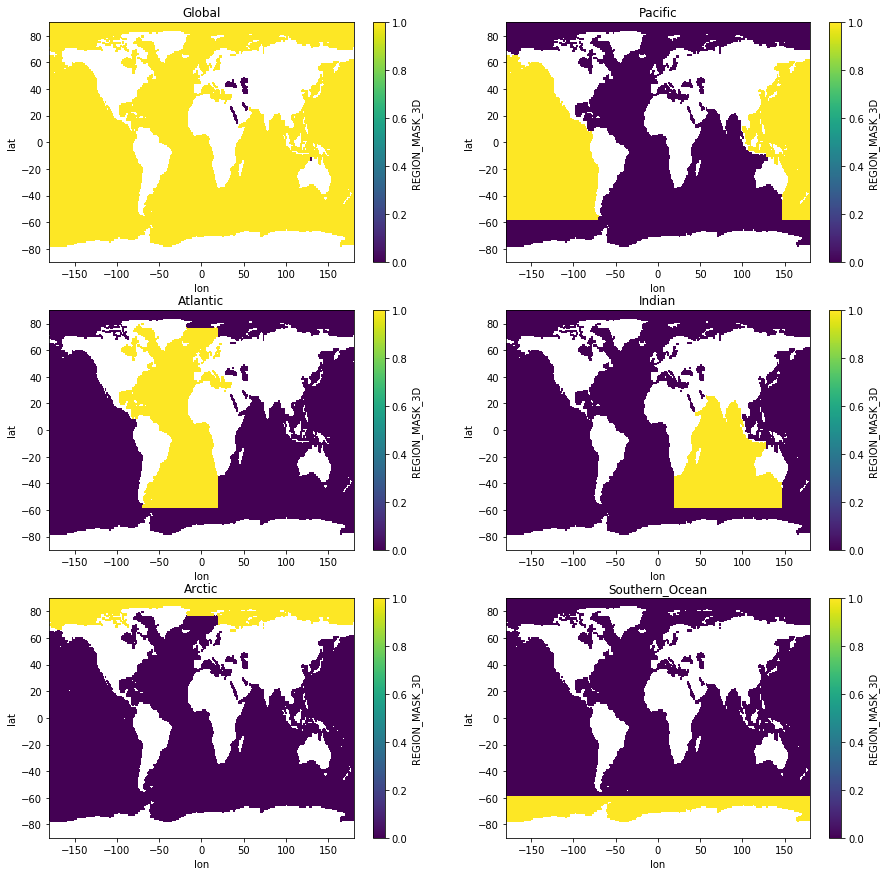

In [4]:
my_regions = OrderedDict([('Global' , [1.,2.,3.,4.,5.,9.,10.,11.,12.,56.]),
                          ('Pacific' , [2.,12.]),
                          ('Atlantic' , [1.,4.,5.,9.]),
                          ('Indian' , [3.,56.]),
                          ('Arctic', [11.]),
                          ('Southern_Ocean' , [10.])])

nlat = len(ds.lat)
nlon = len(ds.lon)
nrgn = len(my_regions)

basin = ds.copy()
basin['REGION_MASK_3D'] = xr.DataArray(np.zeros((nrgn,nlat,nlon)),
                                    dims=('region','lat','lon'))
basin['region_names'] = xr.DataArray(my_regions.keys(),
                                    dims=('region'))

for i,(name,ndx) in enumerate(my_regions.items()):
    tmp = np.zeros((nlat,nlon))
    for n in ndx:
        tmp = np.where(ds.mask.values == n, 1, tmp)
    basin.REGION_MASK_3D.values[i,:,:] = tmp
    basin.REGION_MASK_3D.values = basin.REGION_MASK_3D.where(ds.kmt!=1)
    basin[name] = basin.REGION_MASK_3D.sel(region=i)

fig = plt.figure(figsize=(15,15))
for i in range(nrgn):    
    ax = fig.add_subplot(3,2,i+1)
    basin.REGION_MASK_3D[i,:,:].plot(axes=ax)
    ax.set_title(my_regions.keys()[i])

In [5]:
basin

<xarray.Dataset>
Dimensions:         (lat: 180, lon: 360, nv: 4, region: 6)
Coordinates:
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon             (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
Dimensions without coordinates: nv, region
Data variables:
    xc              (lat, lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 ...
    yc              (lat, lon) float64 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 ...
    xv              (lat, lon, nv) float64 -180.0 -179.0 -179.0 -180.0 ...
    yv              (lat, lon, nv) float64 -90.0 -90.0 -89.0 -89.0 -90.0 ...
    area            (lat, lon) float64 1.079e+08 1.079e+08 1.079e+08 ...
    mask            (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    kmt             (lat, lon) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    mask_orig       (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    REGION_MASK_3D  (region, lat, lon) float64 nan nan nan nan nan na

#### Define inversions regions

Number of regions: 13


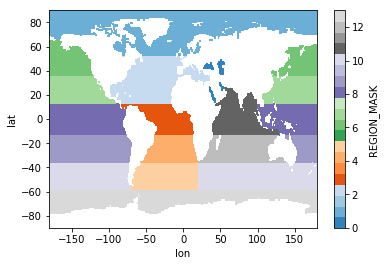

In [6]:
dsG01 = ds.copy()

M = xr.DataArray(np.ones((nlat,nlon)),dims=('lat','lon'))

#-- region 1
my_regions = OrderedDict([
    ('1' , M.where((basin.Arctic==1.) |
                  ((basin.lat>53.) & (basin.Atlantic == 1.)))),
    ('2' , M.where((13.<basin.lat) & (basin.lat<=53.) & (basin.Atlantic == 1.))),
    ('3' , M.where((-13.<basin.lat) & (basin.lat<=13.) & (basin.Atlantic == 1.))),
    ('4' , M.where((-36.<basin.lat) & (basin.lat<=-13.) & (basin.Atlantic == 1.))),
    ('5' , M.where((-58.<basin.lat) & (basin.lat<=-36.) & ((basin.Atlantic == 1.)))), 
    ('6' , M.where((36.<basin.lat) & (basin.lat<=70.) & (basin.Pacific == 1.))),
    ('7' , M.where((13.<basin.lat) & (basin.lat<=36.) & (basin.Pacific == 1.))),
    ('8&9' , M.where((-13.<basin.lat) & (basin.lat<=13.) & (basin.Pacific == 1.))),
    ('10' , M.where((-36.<basin.lat) & (basin.lat<=-13.) & (basin.Pacific == 1.))),     
    ('11&14' , M.where((-58.<basin.lat) & (basin.lat<=-36.) & ((basin.Pacific == 1.)|(basin.Indian == 1.)))),
    ('12' , M.where((-13.<basin.lat) & (basin.lat<=70.) & (basin.Indian == 1.))),    
    ('13' , M.where((-36.<basin.lat) & (basin.lat<=-13.) & (basin.Indian == 1.))),
    ('15' , M.where((-90.<basin.lat) & (basin.lat<=-58.)))])

nrgn = len(my_regions)
print('Number of regions: %d'%nrgn)
dsG01['REGION_MASK_3D'] = xr.DataArray(np.zeros((nrgn,nlat,nlon)),
                                    dims=('region','lat','lon'))

for i,mask_logic in enumerate(my_regions.values()):
    dsG01.REGION_MASK_3D.values[i,:,:] = mask_logic.fillna(0.)
dsG01.REGION_MASK_3D.values = dsG01.REGION_MASK_3D.where(ds.kmt!=1)

dsG01['REGION_MASK'] = dsG01.REGION_MASK_3D.isel(region=0)
for i in range(nrgn):
    dsG01.REGION_MASK.values = np.where(dsG01.REGION_MASK_3D[i,:,:]==1,i+1,dsG01.REGION_MASK)
dsG01.REGION_MASK.plot(cmap='tab20c')


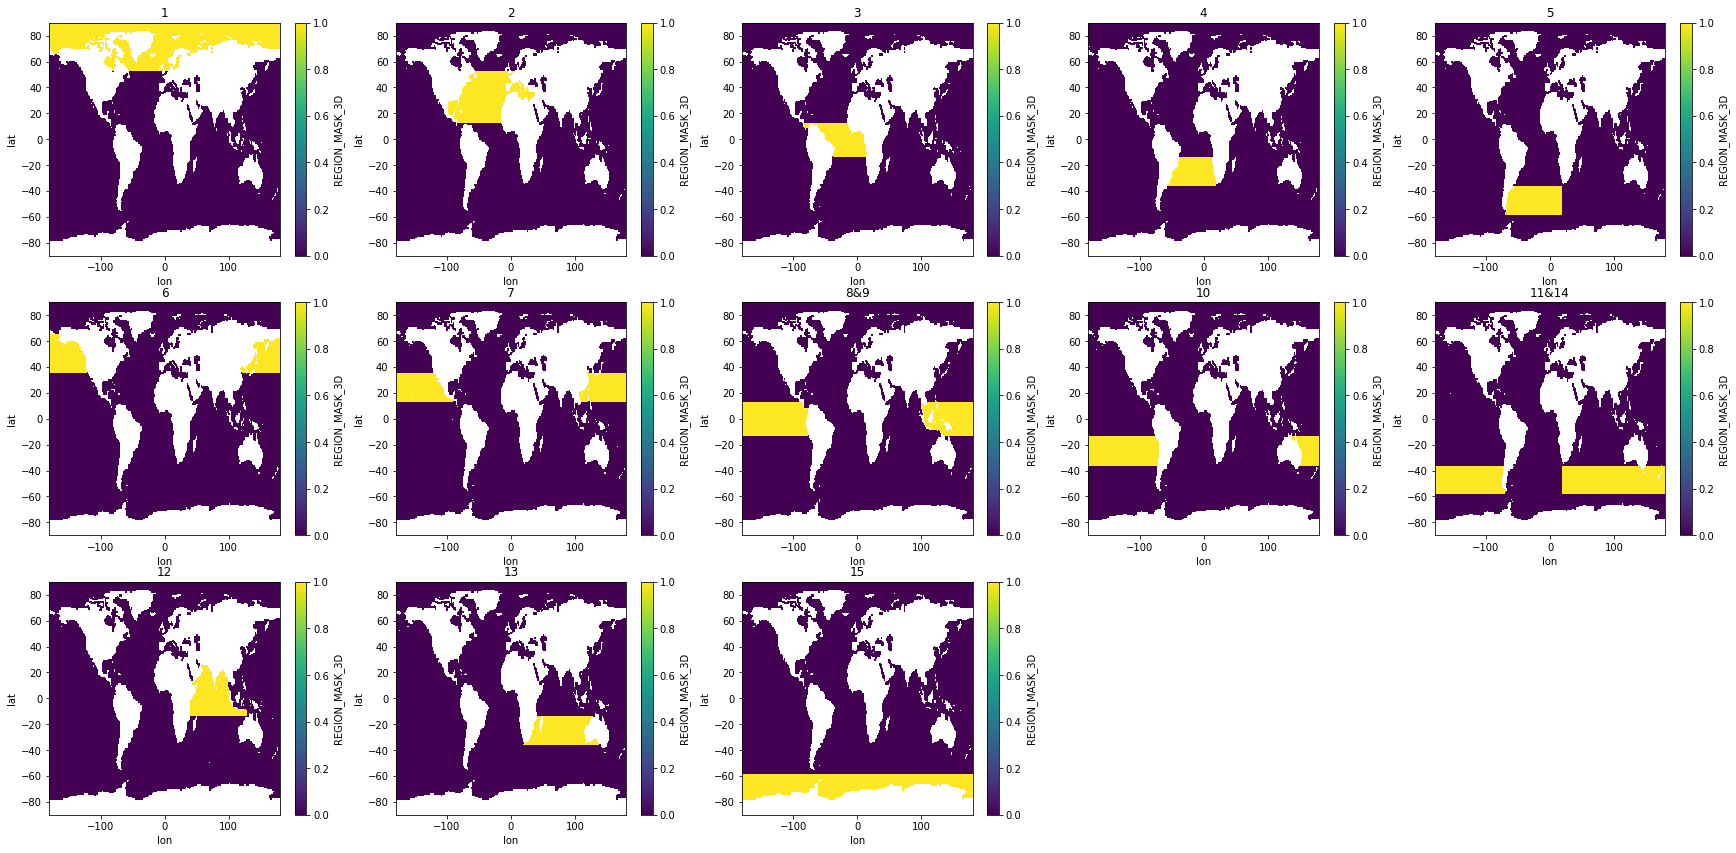

In [7]:
fig = plt.figure(figsize=(30,30))
for i,name in enumerate(my_regions.keys()):
    ax = fig.add_subplot(6,5,i+1)
    dsG01.REGION_MASK_3D[i,:,:].plot(axes=ax)
    ax.set_title(name)    

#### Write the O$_2$ fluxes

Table 3/Fig. 6 of Gruber et al. 2001

Global sum: -0.1000 Tg/yr

Area (10^13 m^2)
1: 1.76
2: 2.93
3: 1.65
4: 1.53
5: 1.55
6: 1.83
7: 3.42
8&9: 5.03
10: 3.54
11&14: 4.83
12: 2.20
13: 2.12
15: 2.44


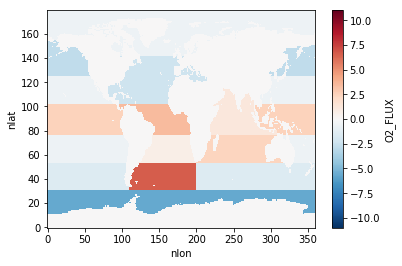

In [8]:
region_flux = OrderedDict([
    ('1' , -9.4 ),
    ('2' , -65.7 ),
    ('3' , 56.7 ),
    ('4' , 10.8 ),
    ('5' , 103.1 ),
    ('6' , -52.0 ),
    ('7' , -20.5 ),
    ('8&9' ,128.2 ),
    ('10' , -20. ),
    ('11&14' , -74.5 ),
    ('12' , 27.5 ),
    ('13' , 52.5 ),
    ('15' , -136.8 )])

Tmolyr_to_molyr = 1e12

print('Global sum: %.4f Tg/yr'%sum(region_flux.values()))

dsG01['O2_FLUX'] = xr.DataArray(np.zeros((nlat,nlon)),dims=('nlat','nlon'))

print('\nArea (10^13 m^2)')
for i,region_name in enumerate(my_regions.keys()):
    area = dsG01.area.where(dsG01.REGION_MASK_3D[i,:,:]==1).fillna(0.).sum()
    print('%s: %.2f'%(region_name,area*1e-13))
    this_region_flux = region_flux[region_name]/area * Tmolyr_to_molyr
    dsG01.O2_FLUX.values = np.where(dsG01.REGION_MASK_3D[i,:,:]==1,this_region_flux,dsG01.O2_FLUX)
    
dsG01.O2_FLUX.plot(vmin=-11.,vmax=11,cmap='RdBu_r')

#### put fluxes on Garcia & Keeling (2001) grid

In [9]:
ny = 160
nx = 320
dx = 360./nx
dy = 180./ny
dsGK01 = grid_tools.generate_latlon_grid(nx=320,ny=160,lon0=-180.)
dsGK01

<xarray.Dataset>
Dimensions:  (lat: 160, lon: 320, nv: 4)
Coordinates:
  * lat      (lat) float64 -89.44 -88.31 -87.19 -86.06 -84.94 -83.81 -82.69 ...
  * lon      (lon) float64 -179.4 -178.3 -177.2 -176.1 -174.9 -173.8 -172.7 ...
Dimensions without coordinates: nv
Data variables:
    xc       (lat, lon) float64 -179.4 -178.3 -177.2 -176.1 -174.9 -173.8 ...
    yc       (lat, lon) float64 -89.44 -89.44 -89.44 -89.44 -89.44 -89.44 ...
    xv       (lat, lon, nv) float64 -180.0 -178.9 -178.9 -180.0 -178.9 ...
    yv       (lat, lon, nv) float64 -90.0 -90.0 -88.88 -88.88 -90.0 -90.0 ...
    area     (lat, lon) float64 1.536e+08 1.536e+08 1.536e+08 1.536e+08 ...

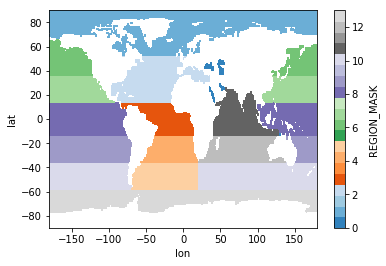

In [10]:
from scipy import interpolate
x,y = np.meshgrid(dsG01.lon,dsG01.lat)
xi,yi = np.meshgrid(dsGK01.lon,dsGK01.lat)
dsGK01['REGION_MASK'] = xr.DataArray(
    interpolate.griddata((x.ravel(),y.ravel()),dsG01.REGION_MASK.values.ravel(),(xi,yi),method='nearest'),
    dims=('lat','lon'))

dsGK01['REGION_MASK_3D'] = xr.DataArray(np.zeros((nrgn,ny,nx)),
                                        dims=('region','lat','lon'))
for i in range(nrgn):
    dsGK01.REGION_MASK_3D.values[i,:,:] = np.where(dsGK01.REGION_MASK[:,:]==i+1,1,0)

dsGK01.REGION_MASK.plot(cmap='tab20c')


Area (10^13 m^2)
1: 1.77
2: 2.89
3: 1.71
4: 1.51
5: 1.58
6: 1.83
7: 3.33
8&9: 5.21
10: 3.44
11&14: 4.91
12: 2.26
13: 2.07
15: 2.33


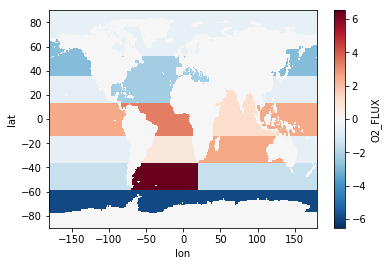

In [11]:
print('\nArea (10^13 m^2)')
dsGK01['O2_FLUX'] = xr.DataArray(np.zeros((ny,nx)),dims=('lat','lon'))
for i,region_name in enumerate(my_regions.keys()):
    area = dsGK01.area.where(dsGK01.REGION_MASK_3D[i,:,:]==1).fillna(0.).sum()
    print('%s: %.2f'%(region_name,area*1e-13))
    this_region_flux = region_flux[region_name]/area * Tmolyr_to_molyr
    dsGK01.O2_FLUX.values = np.where(dsGK01.REGION_MASK_3D[i,:,:]==1,this_region_flux,dsGK01.O2_FLUX)
    
dsGK01.O2_FLUX.plot()

In [12]:
file_G01 = os.path.join(diro['work'],'gruber-etal-2001-o2-ann-flux.1x1.nc')
file_GK01 = os.path.join(diro['work'],'gruber-etal-2001-o2-ann-flux.1.125x1.125.nc')
dsG01.to_netcdf(file_G01)
dsGK01.to_netcdf(file_GK01)